## Note - About file path

You could use the cell above to print the names of the file directories and get the following directories:

```
/kaggle/input/bttai-ajl-2025/sample_submission.csv
/kaggle/input/bttai-ajl-2025/train.csv
/kaggle/input/bttai-ajl-2025/test.csv
/kaggle/input/bttai-ajl-2025/test/test/e0374ae6c1362ff183cfba28ded5421b.jpg
/kaggle/input/bttai-ajl-2025/test/test/437159c605260bdd079af230566af291.jpg
...
...
/kaggle/input/bttai-ajl-2025/train/train/dermatomyositis/11271bdf2598afdd4260db3125e1f6a5.jpg
/kaggle/input/bttai-ajl-2025/train/train/dermatomyositis/732819951dcf2b53d15ea7b8bb123b71.jpg
/kaggle/input/bttai-ajl-2025/train/train/dermatomyositis/6dcc7a8abb5e1c6e670101f4b6231246.jpg
/kaggle/input/bttai-ajl-2025/train/train/dermatomyositis/e63c3b3f0ab8905e204fe467cc7411f9.jpg
...
...
```



## 1. Import Necessary Libraries

In [5]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, Callback
from tensorflow.keras.metrics import F1Score
from sklearn.utils.class_weight import compute_class_weight
import cv2
from tensorflow.keras.optimizers import Adam

# Explanation:
# - pandas and numpy: for data manipulation
# - sklearn: for splitting data and encoding labels
# - tensorflow.keras: for building and training the neural network

## 2. Load Data

Make sure to verify the file paths if you're running on a different platform.

In [6]:
train_df = pd.read_csv('/kaggle/input/bttai-ajl-2025/train.csv')
test_df = pd.read_csv('/kaggle/input/bttai-ajl-2025/test.csv')
train_df['md5hash'] = train_df['md5hash'].astype(str) + '.jpg'
test_df['md5hash'] = test_df['md5hash'].astype(str) + '.jpg'

train_df['file_path'] = train_df['label'] + '/' + train_df['md5hash']

print(train_df.head())

                                md5hash  fitzpatrick_scale  \
0  fd06d13de341cc75ad679916c5d7e6a6.jpg                  4   
1  a4bb4e5206c4e89a303f470576fc5253.jpg                  1   
2  c94ce27e389f96bda998e7c3fa5c4a2e.jpg                  5   
3  ebcf2b50dd943c700d4e2b586fcd4425.jpg                  3   
4  c77d6c895f05fea73a8f3704307036c0.jpg                  1   

   fitzpatrick_centaur                             label nine_partition_label  \
0                    4                 prurigo-nodularis     benign-epidermal   
1                    1  basal-cell-carcinoma-morpheiform  malignant-epidermal   
2                    5                            keloid         inflammatory   
3                    3              basal-cell-carcinoma  malignant-epidermal   
4                    1                 prurigo-nodularis     benign-epidermal   

  three_partition_label            qc  ddi_scale  \
0                benign           NaN         34   
1             malignant           Na

In [7]:
label_encoder = LabelEncoder()
train_df['encoded_label'] = label_encoder.fit_transform(train_df['label'])

train_data, val_data = train_test_split(train_df, test_size=0.2, random_state=42)

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_dir = '/kaggle/input/bttai-ajl-2025/train/train/'

print(train_df['label'].value_counts())
new_labels = train_df['label'].value_counts()
new_labels = new_labels[new_labels > 0]
new_labels = new_labels.index.tolist()
print(new_labels)
train_data = train_data[train_data['label'].isin(new_labels)]
train_data.head(3)

val_data = val_data[val_data['label'].isin(new_labels)]
val_data.head(3)
num_classes = train_data['label'].nunique()
print(f"Number of classes: {num_classes}")

label
squamous-cell-carcinoma               407
basal-cell-carcinoma                  328
folliculitis                          239
acne-vulgaris                         234
melanoma                              181
eczema                                143
acne                                  128
mycosis-fungoides                     127
actinic-keratosis                     122
prurigo-nodularis                     119
kaposi-sarcoma                        109
keloid                                109
dermatomyositis                       106
superficial-spreading-melanoma-ssm     83
pyogenic-granuloma                     79
malignant-melanoma                     78
epidermal-nevus                        64
dyshidrotic-eczema                     58
dermatofibroma                         55
seborrheic-keratosis                   48
basal-cell-carcinoma-morpheiform       43
Name: count, dtype: int64
['squamous-cell-carcinoma', 'basal-cell-carcinoma', 'folliculitis', 'acne-vulgaris', '

## 3. Data Preprocessing


This section demonstrates basic preprocessing techniques. To enhance data quality and model performance, consider incorporating more advanced preprocessing methods.

For further guidance, feel free to take a look at the [Image Preprocessing tutorial](https://colab.research.google.com/drive/1-ItNcRMbZBE6BCwPT-wD8m3YmHqwHxme?usp=sharing)  available in the 'Resources' section of this Kaggle competition.


In [8]:
def create_generator(dataframe, directory, batch_size=32, target_size=(128, 128)):
    """
    Template function to create image generators.
    Students should complete this function to load images and labels properly.
    """
    # Fill in the correct flow_from_dataframe parameters
    generator = train_datagen.flow_from_dataframe(
        dataframe=dataframe,
        directory=directory,
        x_col='file_path',  # Use combined path
        y_col='label',
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False, # for now
        validate_filenames=False  # Disable strict filename validation
    )
    return generator

Found 2288 non-validated image filenames belonging to 21 classes.


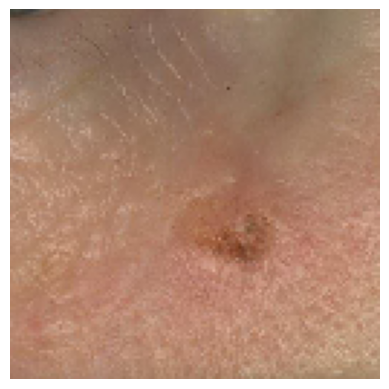

In [9]:
# Display an image from train_data

import matplotlib.pyplot as plt
import numpy as np

# Get a batch of images and labels from the generator
train_generator = create_generator(train_data, train_dir)
images, labels = next(train_generator)

# Choose an image to display (e.g., the first image in the batch)
image_index = 0
img = images[image_index]

# Display the image
plt.imshow(img)
plt.axis('off') # Hide axes
plt.show()

## 4. Build the model


In [10]:
model = Sequential([
    layers.Conv2D(64, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu', input_shape=(128, 128, 3)), # adding batch normalization
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3), # changed Dropout layer from 0.05 (too low) to 0.3 to reduce overfitting
    layers.Dense(num_classes, activation='softmax')  # Output layer
])

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy', F1Score(average='weighted')]
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## 5. Train the Model


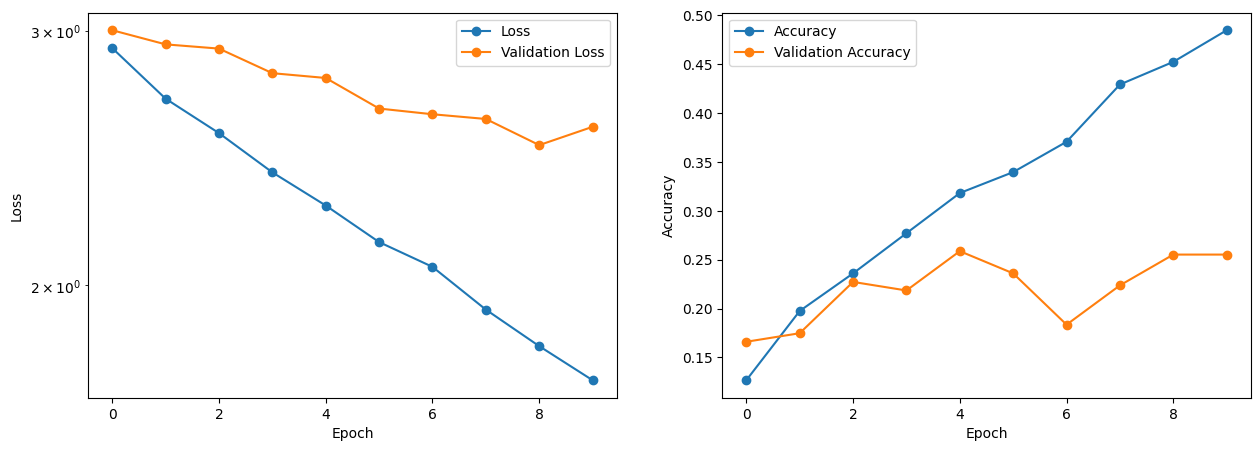

Epoch 10: Loss = 1.7194184064865112, Val Loss = 2.576037883758545, Accuracy = 0.48470279574394226, Val Accuracy = 0.25524476170539856
72/72 ━━━━━━━━━━━━━━━━━━━━ 108s 1s/step - accuracy: 0.4954 - f1_score: 0.4829 - loss: 1.7102 - val_accuracy: 0.2552 - val_f1_score: 0.2277 - val_loss: 2.5760


In [11]:
from IPython.display import clear_output  # For dynamically updating the plot
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import Callback

class PlotLearning(Callback):
    """
    Callback to plot the learning curves dynamically during training.
    """
    def on_train_begin(self, logs=None):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        self.logs = []

        plt.ion()  # Turn on interactive mode

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        
        # Append metrics, using default values if None
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss', 0))
        self.val_losses.append(logs.get('val_loss', 0))
        self.acc.append(logs.get('accuracy', 0))
        self.val_acc.append(logs.get('val_accuracy', 0))
        self.i += 1

        clear_output(wait=True)  # Clear previous output to update dynamically
        plt.figure(figsize=(15, 5))

        # Loss Plot
        plt.subplot(1, 2, 1)
        plt.yscale('log')  # Log scale for better visualization
        plt.plot(self.x, self.losses, label="Loss", marker='o')
        plt.plot(self.x, self.val_losses, label="Validation Loss", marker='o')
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()

        # Accuracy Plot
        plt.subplot(1, 2, 2)
        plt.plot(self.x, self.acc, label="Accuracy", marker='o')
        plt.plot(self.x, self.val_acc, label="Validation Accuracy", marker='o')
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.legend()

        plt.show()
        print(f"Epoch {epoch+1}: Loss = {logs.get('loss', 0)}, Val Loss = {logs.get('val_loss', 0)}, "
              f"Accuracy = {logs.get('accuracy', 0)}, Val Accuracy = {logs.get('val_accuracy', 0)}")

%matplotlib inline

# Usage example:
plot_callback = PlotLearning()

# Define train_generator and val_generator before training
train_generator = create_generator(train_data, train_dir)
val_generator = create_generator(val_data, train_dir)

# Now fit the model
plot_callback = PlotLearning()

model.fit(train_generator, 
          validation_data=val_generator, 
          epochs=10, 
          callbacks=[plot_callback])

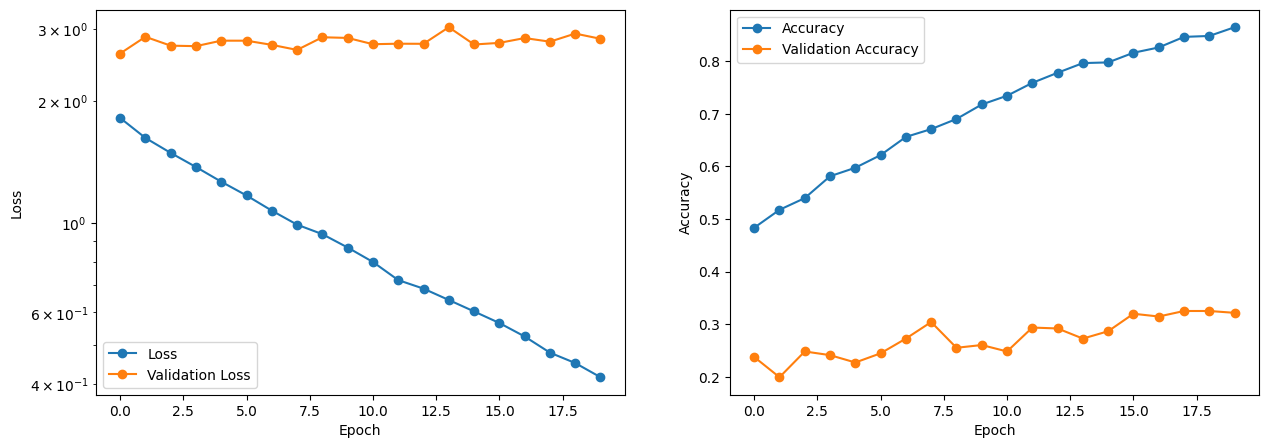

Epoch 20: Loss = 0.41529539227485657, Val Loss = 2.8412551879882812, Accuracy = 0.8645104765892029, Val Accuracy = 0.3216783106327057
72/72 ━━━━━━━━━━━━━━━━━━━━ 106s 1s/step - accuracy: 0.8656 - f1_score: 0.8657 - loss: 0.4174 - val_accuracy: 0.3217 - val_f1_score: 0.3136 - val_loss: 2.8413


In [12]:
# early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
all_labels = train_df['label']

class_weights = compute_class_weight('balanced', classes=np.unique(all_labels), y=all_labels)
class_weight_dict = {i: class_weights[i] for i in range(num_classes)}

plot = PlotLearning() # create an instance of the PlotLearning class

history = model.fit(
  train_generator,
  epochs=20,  # Adjust the number of epochs as needed
  class_weight=class_weight_dict,
  validation_data=val_generator,
  # callbacks=[early_stopping, plot] # include the plot callback
  callbacks=[plot]
)

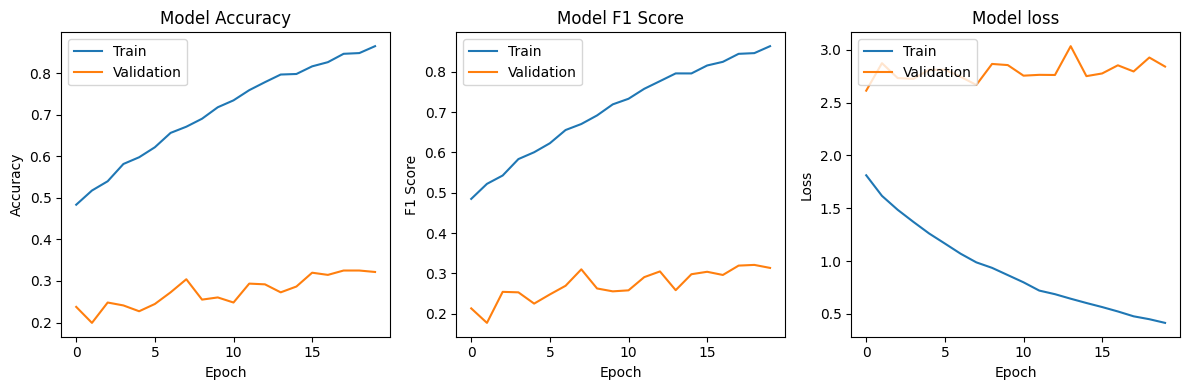

In [13]:
import matplotlib.pyplot as plt

# Plot training & validation F1 score values
plt.figure(figsize=(12, 4))  # Adjust figure size if needed

plt.subplot(1, 3, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 3, 2)
plt.plot(history.history['f1_score'])
plt.plot(history.history['val_f1_score'])
plt.title('Model F1 Score')
plt.ylabel('F1 Score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 3, 3)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

## 6. Make Predictions on Test Data

In [14]:
def preprocess_test_data(test_df, directory):
    test_datagen = ImageDataGenerator(rescale=1./255)
    test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_df,
        directory=directory,
        x_col='md5hash',
        y_col=None,
        target_size=(128, 128),
        batch_size=32,
        class_mode=None,
        shuffle=False,
        validate_filenames=False  # Disable strict filename validation
    )
    return test_generator

In [15]:
test_df.head(2)

,md5hash,fitzpatrick_scale,fitzpatrick_centaur,qc,ddi_scale
0,0844ae634f0e6e7ef1f73c2aeecbae0e.jpg,2,2,NaN,12
1,3b290d262098f761d719aa07cf36c040.jpg,4,3,NaN,34


In [16]:
# Load test data
test_dir = '/kaggle/input/bttai-ajl-2025/test/test/'
test_generator = preprocess_test_data(test_df, test_dir)

Found 1227 non-validated image filenames.


## 7. Generate Predictions

In [17]:
# Generate predictions based on the trained model
# Then, save the predictions into a CSV file for submission

predictions = model.predict(test_generator)

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


39/39 ━━━━━━━━━━━━━━━━━━━━ 20s 508ms/step


In [18]:
predicted_labels = np.argmax(predictions, axis=1)
top_labels = label_encoder.inverse_transform(predicted_labels)
print("Predictions:", top_labels, '\n')
print("Unique:", np.unique(top_labels), '\n') # ensure the model isn't predicting the same thing every time
print(f"{len(np.unique(top_labels))}/{num_classes} classes were predicted")

Predictions: ['eczema' 'folliculitis' 'basal-cell-carcinoma' ... 'pyogenic-granuloma'
 'squamous-cell-carcinoma' 'squamous-cell-carcinoma'] 

Unique: ['acne' 'acne-vulgaris' 'actinic-keratosis' 'basal-cell-carcinoma'
 'basal-cell-carcinoma-morpheiform' 'dermatofibroma' 'dermatomyositis'
 'dyshidrotic-eczema' 'eczema' 'epidermal-nevus' 'folliculitis'
 'kaposi-sarcoma' 'keloid' 'malignant-melanoma' 'melanoma'
 'mycosis-fungoides' 'prurigo-nodularis' 'pyogenic-granuloma'
 'seborrheic-keratosis' 'squamous-cell-carcinoma'
 'superficial-spreading-melanoma-ssm'] 

21/21 classes were predicted


In [19]:
# remove .jpg extension
test_df['hash'] = test_df['md5hash'].apply(lambda x: os.path.splitext(x)[0])
test_df['hash'].head(3)

0    0844ae634f0e6e7ef1f73c2aeecbae0e
1    3b290d262098f761d719aa07cf36c040
2    cf561d08ac46d0fda678bff6621005ee
Name: hash, dtype: object

In [20]:
final_df = pd.DataFrame({'md5hash': test_df['hash'], 'label': top_labels})
final_df.head()

,md5hash,label
0,0844ae634f0e6e7ef1f73c2aeecbae0e,eczema
1,3b290d262098f761d719aa07cf36c040,folliculitis
2,cf561d08ac46d0fda678bff6621005ee,basal-cell-carcinoma
3,e6371069be05c6b0a95b4b3f1bacc9a5,acne-vulgaris
4,f76cddb37265f97508f159078dcc7e7c,folliculitis


In [21]:
# Print location of the csv file

import os
print(os.getcwd())

print("done")

/kaggle/working
done


An error occurred: [Errno 21] Is a directory: '/kaggle/working'
